### Imports and params

In [1]:
from IPython.display import clear_output

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

from sklearn import tree
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from tqdm import tqdm

In [2]:
parameters = {
    'model_name': 'autoencoder.pth',
    'batch_size': 64,
    'val_size': 0.05,
    'epochs': 5,
    'seed': 47,
    'lr': 1e-3,
    'dim_code': 32
}

In [3]:
torch.manual_seed(parameters['seed'])

### Data preparation

In [4]:
class TrainValDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
class TestDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.transform = transform

        with open(file_path, 'r') as file:
            self.data = [line.split() for line in file]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(f'data/anomaly-dataset/test/imgs/{image_path}').convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        label = int(label)

        return image, label

In [6]:
train_transforms = transforms.Compose(
    [
     transforms.Resize((32, 48)),
     transforms.CenterCrop((32, 32)), 
     transforms.GaussianBlur(kernel_size=7, sigma=1),
     transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
     transforms.Resize((32, 48)),
     transforms.CenterCrop((32, 32)),
     transforms.ToTensor(),
     transforms.GaussianBlur(kernel_size=7, sigma=1),
    ]
)

train_val_set = ImageFolder(root='data/anomaly-dataset/train/')
proliv_set = ImageFolder(root='data/anomaly-dataset/proliv/', transform=test_transforms)
test_dataset = TestDataset(file_path='data/anomaly-dataset/test/test_annotation.txt', transform=test_transforms)

val_size = int(parameters['val_size'] * len(train_val_set))
train_size = len(train_val_set) - val_size
train_set, val_set = random_split(train_val_set, [train_size, val_size])
train_set = TrainValDataset(train_set, transform=train_transforms)
val_set = TrainValDataset(val_set, transform=test_transforms)

train_loader = DataLoader(train_set, batch_size=parameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=parameters['batch_size'], shuffle=False)
proliv_loader = DataLoader(proliv_set, batch_size=parameters['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=parameters['batch_size'], shuffle=False)

In [7]:
def build_graphs(original, reconstructed, cnt=10):
    plt.figure(figsize=(18, 3))
    for k in range(cnt):
        plt.subplot(2, cnt, k + 1)
        plt.imshow(original[k].permute(1, 2, 0).to('cpu').numpy())
        plt.title('Real')
        plt.axis('off')
        plt.subplot(2, cnt, k + cnt + 1)
        plt.imshow(np.clip(reconstructed[k].permute(1, 2, 0).detach().to('cpu').numpy(), 0, 1))
        plt.title('Reconstructed')
        plt.axis('off')

### Autoencoder model

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code=32):
        super().__init__()
        self.dim_code = dim_code
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        self.flatten = nn.Flatten()
        
        self.encoder_fc = nn.Linear(16 * 8 * 8, dim_code)
        self.decoder_fc = nn.Linear(dim_code, 16 * 8 * 8)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        latent_code = self.encoder_fc(self.flatten(x))
                                      
        x = self.decoder_fc(latent_code).view(-1, 16, 8, 8)
        reconstruction = self.decoder(x)
        return reconstruction

### Training

In [9]:
criterion = F.mse_loss
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder(dim_code=parameters['dim_code']).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=parameters['lr'])

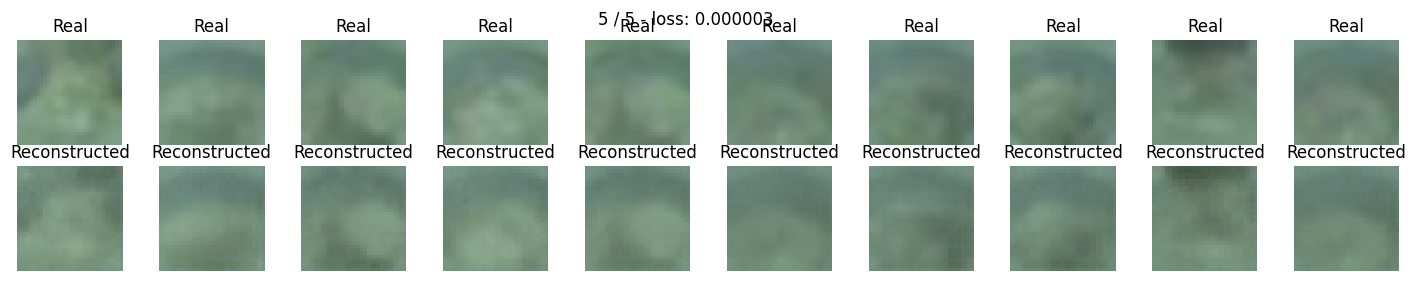

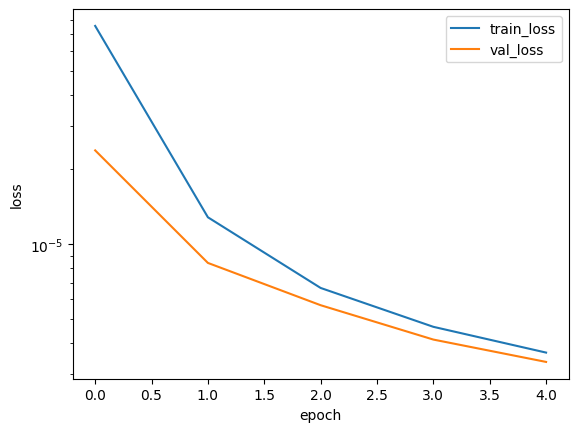

100%|██████████| 5/5 [01:24<00:00, 16.93s/it]


In [10]:
train_losses = []
val_losses = []
epochs = parameters['epochs']
for epoch in tqdm(range(epochs)):
    autoencoder.train()
    train_loss_per_epoch = 0.0
    processed_data = 0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device) 
        optimizer.zero_grad()
        reconstructed = autoencoder(X_batch)
        loss = criterion(reconstructed, X_batch)
        loss.backward() 
        optimizer.step()  
        train_loss_per_epoch += loss.item()
        processed_data += X_batch.size(0)
    
    train_losses.append(train_loss_per_epoch / processed_data)

    val_loss_per_epoch = 0.0
    processed_data = 0
    autoencoder.eval()
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            reconstructed_val = autoencoder(X_batch)
            loss = criterion(reconstructed_val, X_batch)
            val_loss_per_epoch += loss.item()
            processed_data += X_batch.size(0)
    build_graphs(X_batch, reconstructed_val)
    val_losses.append(val_loss_per_epoch / processed_data)
    clear_output(wait=True)
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, val_losses[-1]))
    plt.show()
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale('log')
    plt.legend()
    plt.show()

In [11]:
torch.save(autoencoder.state_dict(), parameters['model_name'])

### Threshold search

In [12]:
def compute_mse(data, reconstructed):
    mse_list = []

    for orig_image, reconstructed_image in zip(data, reconstructed):
        mse = F.mse_loss(orig_image, reconstructed_image)
        mse_list.append(mse.item())
    return mse_list

In [13]:
orig_data = torch.tensor([])
for images, _ in val_loader:
    orig_data = torch.cat((orig_data, images), dim=0)

proliv_data = torch.tensor([])
for images, _ in proliv_loader:
    proliv_data = torch.cat((proliv_data, images), dim=0)


In [14]:
autoencoder.eval()
with torch.no_grad():
    orig_reconstructed = autoencoder(orig_data.to(device)).cpu().detach()
    proliv_reconstructed = autoencoder(proliv_data.to(device)).cpu().detach()

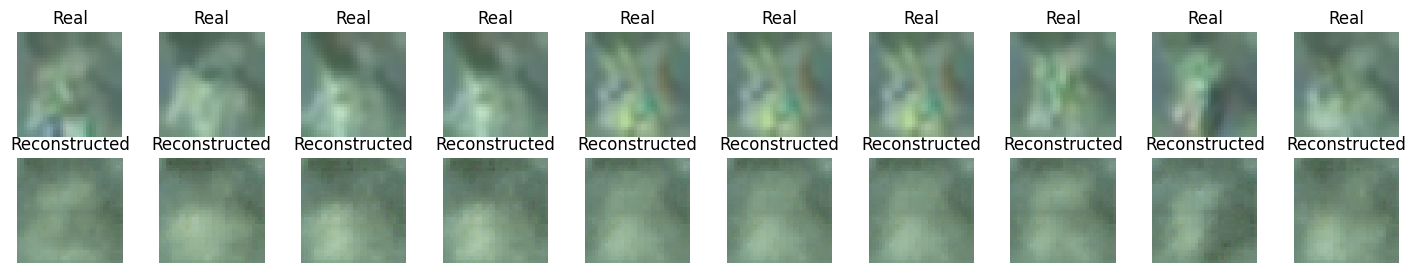

In [15]:
build_graphs(proliv_data, proliv_reconstructed)

In [16]:
orig_mse_list = compute_mse(orig_data, orig_reconstructed)
proliv_mse_list = compute_mse(proliv_data, proliv_reconstructed)

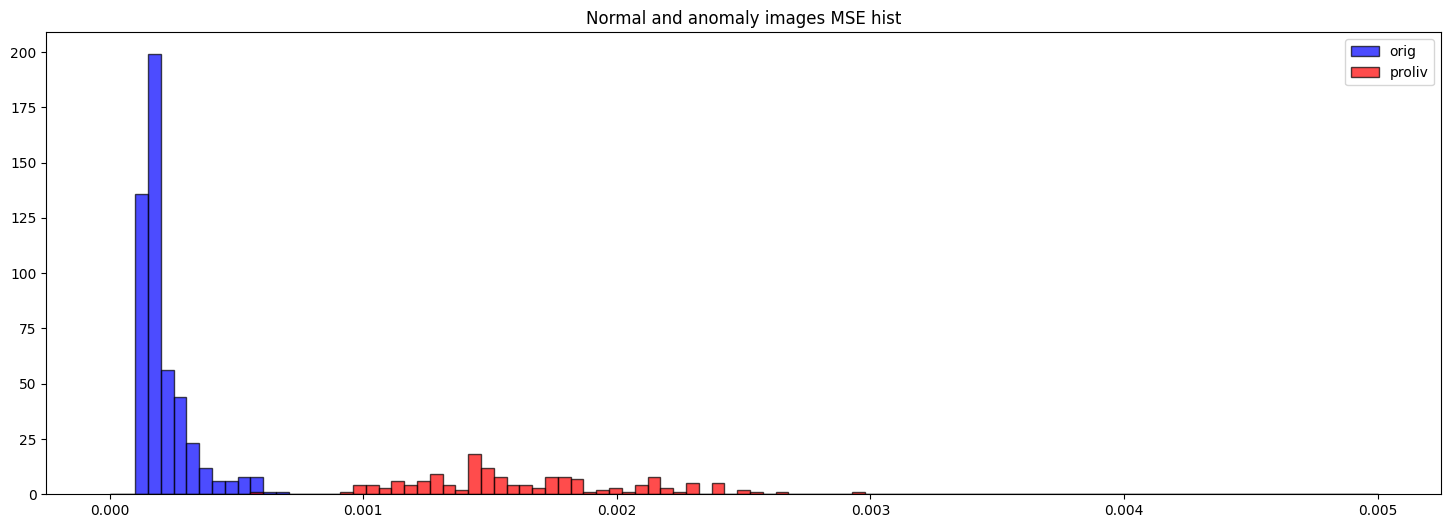

In [17]:
plt.figure(figsize=(18, 6))
plt.hist(orig_mse_list, color='blue', edgecolor='black', alpha=0.7, label='orig', bins=np.linspace(0, 0.005, 100))
plt.hist(proliv_mse_list, color='red', edgecolor='black', alpha=0.7, label = 'proliv', bins=np.linspace(0, 0.005, 100))
plt.title('Normal and anomaly images MSE hist')
plt.legend()
None

Text(0.5, 1.0, 'Found threshold')

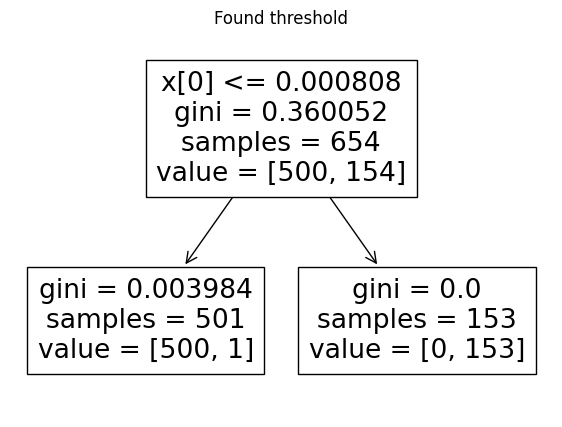

In [18]:
model = tree.DecisionTreeClassifier(max_depth=1, criterion='gini').fit(X=np.array(orig_mse_list + proliv_mse_list).reshape(-1, 1), 
                                                                       y=[0] * len(orig_mse_list) + [1] * len(proliv_mse_list))
plt.figure(figsize=(7,5))
_ = tree.plot_tree(model, precision=6)
plt.title('Found threshold')

### Testing

In [20]:
mse_test = []
labels_test = []
for images, labels in test_dataloader:
    images_reconstructed = autoencoder(images.to(device)).cpu().detach()
    labels_test += labels
    mse = compute_mse(images_reconstructed, images)
    mse_test.extend(mse)

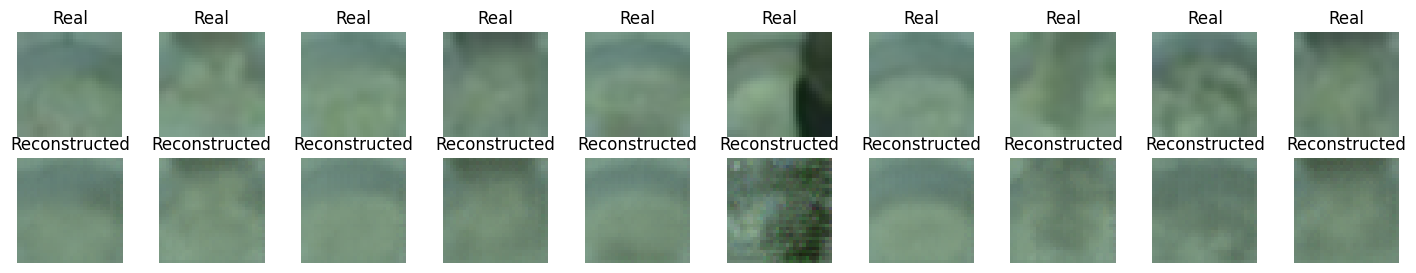

In [21]:
build_graphs(images, images_reconstructed)

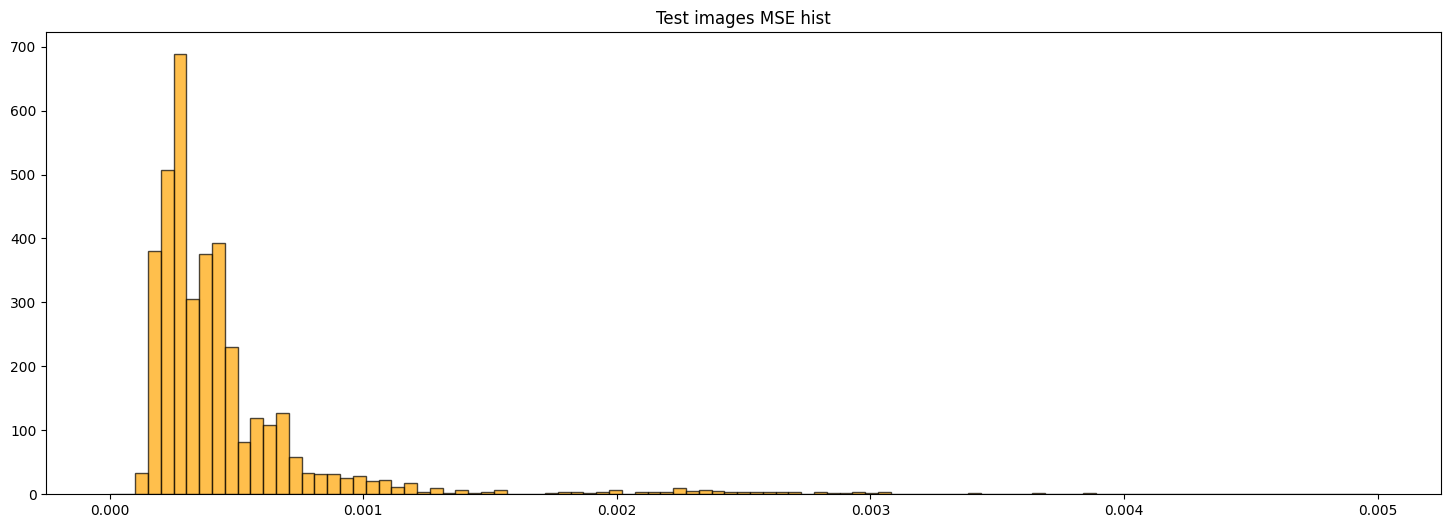

In [22]:
plt.figure(figsize=(18, 6))
plt.hist(mse_test, color = 'orange', edgecolor = 'black', alpha=0.7, bins=np.linspace(0, 0.005, 100))
plt.title('Test images MSE hist')
None

In [23]:
pred = model.predict(np.array(mse_test).reshape(-1, 1))

In [24]:
tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()
print(f"TPR = {tp/(tp+fn):.3f}\nFPR = {tn/(tn+fp):.3f}")

TPR = 0.930
FPR = 0.937
